### Import module

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from timm.scheduler import CosineLRScheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models

from dsets import ImageDataset
from models import UNetWrapper

/home/takafumi/MyAIComp/SonyDice/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-01 16:09:40.543285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 16:09:40.543338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 16:09:40.545282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 16:09:40.691631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### データ読み込み

In [2]:
X_train = np.load('/mnt/c/Users/user/MyData/SonyDice/X_train.npy')
X_train = np.reshape(X_train, (-1, 20, 20))
X_train.shape

(200000, 20, 20)

In [3]:
X_test = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test_renew.npy')
X_test = np.reshape(X_test, (-1, 20, 20))
X_test.shape

(24922, 20, 20)

### データセットの作成

##### Gaussian noise

In [4]:
imgs_gaus = []
for i in range(X_train.shape[0]):
    img = X_train[i, :].copy()

    sigma = random.randint(1, 90)
    noise = np.random.normal(0, sigma, img.shape)

    img_noised = img.astype(np.float64) + noise
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)

    imgs_gaus.append(img_noised)

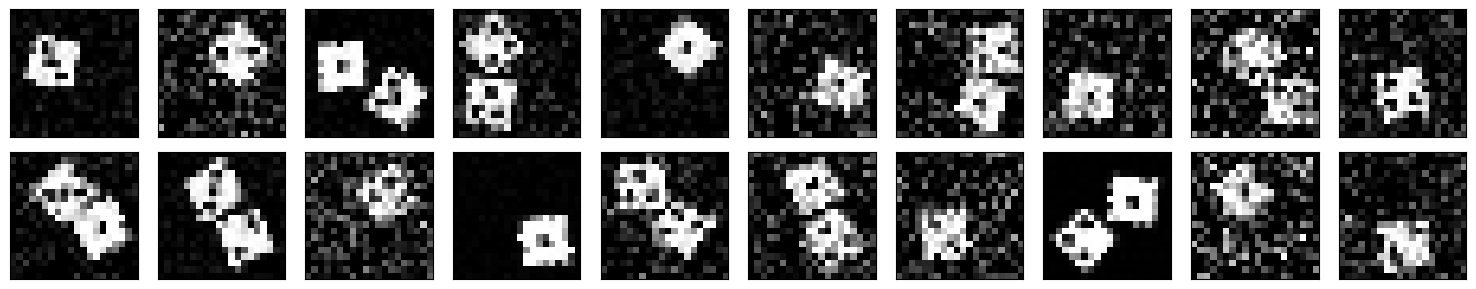

In [5]:
n = 20
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for cnt, i in enumerate(range(n)):
    ax = fig.add_subplot(n//10, 10, cnt+1)
    plt.imshow(imgs_gaus[i], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

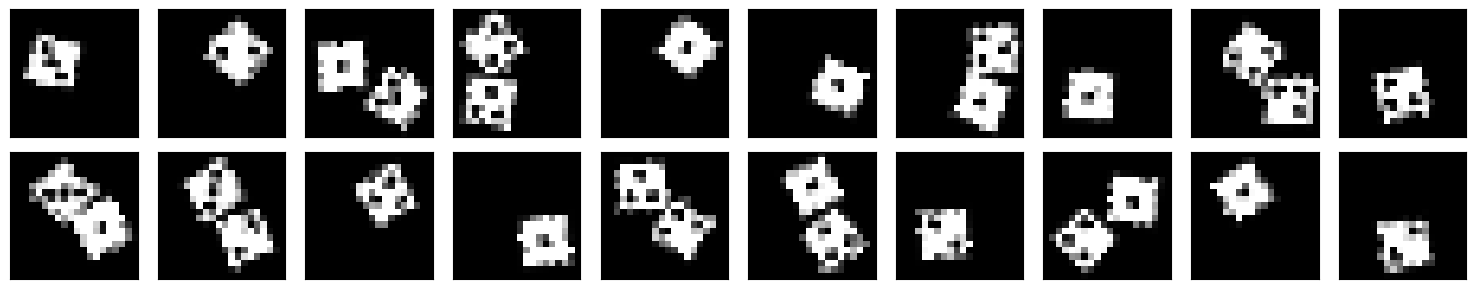

In [6]:
targets = [X_train[i, :] for i in range(X_train.shape[0])]
n = 20
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for cnt, i in enumerate(range(n)):
    ax = fig.add_subplot(n//10, 10, cnt+1)
    plt.imshow(targets[i], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

##### データの平均, 標準偏差の算出

In [7]:
from torchvision import transforms
from sklearn.model_selection import train_test_split

trn_imgs, val_imgs, trn_targets, val_targets = \
    train_test_split(imgs_gaus, targets, train_size=0.8, random_state=1)

image_ToTensor = transforms.ToTensor()

# 訓練データの平均
import torch
trn_img_sum = 0
for trn_img in trn_imgs:
    img_t = image_ToTensor(trn_img)
    trn_img_sum += torch.sum(img_t[0])
# print(trn_img_sum)
trn_mean = trn_img_sum / (20*20*len(trn_imgs))
print(f'訓練データの平均: {trn_mean}')

# 訓練データの標準偏差
trn_img_s2 = 0
for trn_img in trn_imgs:
    img_t = image_ToTensor(trn_img)
    trn_img_s2 += torch.sum((img_t[0] - trn_mean)**2)
trn_std = torch.sqrt(trn_img_s2/(20*20*len(trn_imgs)))
print(f'訓練データの標準偏差: {trn_std}')   

# 検証データ
import torch
val_img_sum = 0
for val_img in val_imgs:
    img_t = image_ToTensor(val_img)
    val_img_sum += torch.sum(img_t[0])
# print(val_img_sum)
val_mean = val_img_sum / (20*20*len(val_imgs))
print(f'検証データの平均: {val_mean}')

# 訓練データの標準偏差
val_img_s2 = 0
for val_img in val_imgs:
    img_t = image_ToTensor(val_img)
    val_img_s2 += torch.sum((img_t[0] - trn_mean)**2)
val_std = torch.sqrt(val_img_s2/(20*20*len(val_imgs)))
print(f'検証データの標準偏差: {val_std}')

訓練データの平均: 0.21524636447429657
訓練データの標準偏差: 0.3262338638305664
検証データの平均: 0.21521513164043427
検証データの標準偏差: 0.3259769380092621


### データセットの作成

In [8]:
def dataTransformer(img, target, data_type):
    if data_type == 'trn':
        img_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.21524), (0.32625))
        ])
    elif data_type == 'val':
        img_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.21520), (0.32602))
        ])
    
    img_t = img_transformer(img)
    target_t = torch.tensor(target/255, dtype=torch.float32)

    return img_t, target_t

In [9]:
class DenoiseDataset(Dataset):
    def __init__(self, data_type):
        assert data_type in ['trn', 'val'], 'check args data_type'

        self.data_type = data_type
        
        trn_imgs, val_imgs, trn_targets, val_targets = train_test_split(imgs_gaus, targets, train_size=0.8, random_state=1)

        if data_type == 'trn':
            self.imgs = trn_imgs
            self.targets = trn_targets
        elif data_type == 'val':
            self.imgs = val_imgs
            self.targets = val_targets
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        target = self.targets[idx]
        img_t, target_t = dataTransformer(img, target, self.data_type)

        return img_t, target_t.unsqueeze(0)

In [10]:
BATCH_SIZE = 128

In [11]:
train_ds = DenoiseDataset(data_type='trn')
valid_ds = DenoiseDataset(data_type='val')

In [12]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    drop_last=True
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### 学習

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
model = UNetWrapper(in_channels=1, 
                    n_classes=1, 
                    depth=3, 
                    wf=4, 
                    padding=True,
                    batch_norm=True, 
                    up_mode='upconv')
model.to(device)

UNetWrapper(
  (input_batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (unet): UNet(
    (down_path): ModuleList(
      (0): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): ReLU()
          (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): ReLU()
          (5): Bat

In [15]:
# log_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
# writer = SummaryWriter(log_dir=f"./log/regnet32_{log_time}/")

In [16]:
torch.cuda.empty_cache()

In [17]:
EPOCH_NUM = 3
VAL_CADENSE = 1
L_COEF = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH_NUM, eta_min=1e-6)

# scheduler = CosineLRScheduler(
#     optimizer,
#     t_initial=100,
#     lr_min=1e-7,
#     warmup_t=3,
#     warmup_lr_init=1e-6,
#     warmup_prefix=True
# )

criterion = nn.MSELoss()

In [18]:
#######################################################
# 保存先フォルダの設定を確認する!!
#######################################################

pbar = tqdm(range(EPOCH_NUM))

for epoch in pbar:
    # モデルを学習モードにする
    model.train()

    # lossの保存リスト
    loss_epoch = []

    # バッチごとに処理する
    for iter_num, (img, target_img) in enumerate(train_dl):
        img = img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()

        l2_loss = 0.0
       
        with torch.autocast("cuda"):
            pred_img = model(img)

            # 重みの計算
            for name, param in model.named_parameters():
                # l1_loss += param.abs().sum()
                l2_loss += torch.norm(param)**2

            ce_loss = criterion(pred_img, target_img)

            # loss = criterion(pred_img, target_img) + L_COEF*(l2_loss+l1_loss)
            loss = ce_loss + L_COEF*l2_loss/BATCH_SIZE

        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch/Iter {epoch}/{iter_num}")

        loss_tmp = ce_loss.to('cpu').detach().numpy().copy()
        
        # weight_tmp = (L_COEF*(l2_loss+l1_loss)).to('cpu').detach().numpy().copy()
        weight_tmp = (L_COEF*(l2_loss)).to('cpu').detach().numpy().copy()

        # lossを記録
        loss_epoch.append(loss_tmp)

    loss_mean = sum(loss_epoch)/len(loss_epoch)

    # writer.add_scalar("train/loss", ce_loss.item(), epoch)
    print(f"trn loss: {loss_mean:.4f}")
        
    scheduler.step(epoch)

    # validation
    if epoch == 0 or epoch % VAL_CADENSE == 0 or epoch == EPOCH_NUM-1:
        # 検証モードにする
        model.eval()

        # 検証データのloss
        loss_epoch = []

        for iter_num, (img, target_img) in enumerate(valid_dl):
            img = img.to(device)
            target_img = target_img.to(device)

            with torch.no_grad(), torch.autocast("cuda"):
                pred_img = model(img)
                loss = criterion(pred_img, target_img)

            # lossを記録
            loss_batch = loss.to('cpu').detach().numpy().copy()
            loss_epoch.append(loss_batch)

        loss_mean = sum(loss_epoch)/len(loss_epoch)
        # writer.add_scalar("valid/loss", loss.item(), epoch)
        print(f"val loss: {loss_mean:.4f}")

        save_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
        
        # torch.save(model.state_dict(), f'/mnt/c/Users/user/MyData/SonyDice/models/UNet/E{epoch}_{save_time}.pt')

# writer.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch/Iter 0/1249:   0%|          | 0/3 [01:02<?, ?it/s]

trn loss: 0.0336


Epoch/Iter 1/3:  33%|███▎      | 1/3 [01:10<02:20, 70.04s/it]   

val loss: 0.0132


Epoch/Iter 1/1249:  33%|███▎      | 1/3 [02:05<02:20, 70.04s/it]

trn loss: 0.0111


Epoch/Iter 2/3:  67%|██████▋   | 2/3 [02:12<01:05, 65.46s/it]   

val loss: 0.0087


Epoch/Iter 2/1249:  67%|██████▋   | 2/3 [03:09<01:05, 65.46s/it]

trn loss: 0.0075


Epoch/Iter 2/1249: 100%|██████████| 3/3 [03:16<00:00, 65.61s/it]

val loss: 0.0066


### 予測

##### testデータの平均と標準偏差

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
test_imgs = [X_test[i, :] for i in range(X_test.shape[0])]

image_ToTensor = transforms.ToTensor()

# 訓練データの平均
import torch
test_img_sum = 0
for test_img in test_imgs:
    img_t = image_ToTensor(test_img)
    test_img_sum += torch.sum(img_t[0])
# print(test_img_sum)
test_mean = test_img_sum / (20*20*len(test_imgs))
print(f'訓練データの平均: {test_mean}')

# 訓練データの標準偏差
test_img_s2 = 0
for test_img in test_imgs:
    img_t = image_ToTensor(test_img)
    test_img_s2 += torch.sum((img_t[0] - test_mean)**2)
test_std = torch.sqrt(test_img_s2/(20*20*len(test_imgs)))
print(f'訓練データの標準偏差: {test_std}')   

訓練データの平均: 0.2771272659301758
訓練データの標準偏差: 0.40467026829719543


In [21]:
def testTransformer(img):
    img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.27713), (0.40467))
    ])
    
    img_t = img_transformer(img)

    return img_t

In [22]:
# Testデータ用のDataset
class DenoiseTestDataset(Dataset):
    '''Test Dataset クラス (サイコロを一つ持つ画像)
    Attributes:
        imgs: testデータの画像のリスト
    '''
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = testTransformer(img)
    
        return img_t

In [23]:
imgs_test = [X_test[i, :] for i in range(len(X_test))]

In [24]:
BATCH_SIZE = 128
test_ds = DenoiseTestDataset(imgs=imgs_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
model = UNetWrapper(in_channels=1, 
                    n_classes=1, 
                    depth=3, 
                    wf=4, 
                    padding=True,
                    batch_norm=True, 
                    up_mode='upconv')
model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/UNet/E9_2023-11-01_01-29.pt'))
model.to(device)

UNetWrapper(
  (input_batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (unet): UNet(
    (down_path): ModuleList(
      (0): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): ReLU()
          (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): ReLU()
          (5): Bat

In [26]:
torch.cuda.empty_cache()

In [27]:
pred_imgs = np.zeros((len(test_ds), 20, 20), dtype='uint8')
model.eval()

for iter_num, img in tqdm(enumerate(test_dl), total=len(test_dl)):

    img = img.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        pred_img = model(img)
        pred_img_np = pred_img.to('cpu').detach().squeeze(1).numpy().copy() * 255
        pred_img_np = np.clip(pred_img_np, 0, 255).astype(np.uint8)
        pred_imgs[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE, :, :] = pred_img_np

100%|██████████| 195/195 [00:04<00:00, 43.35it/s]


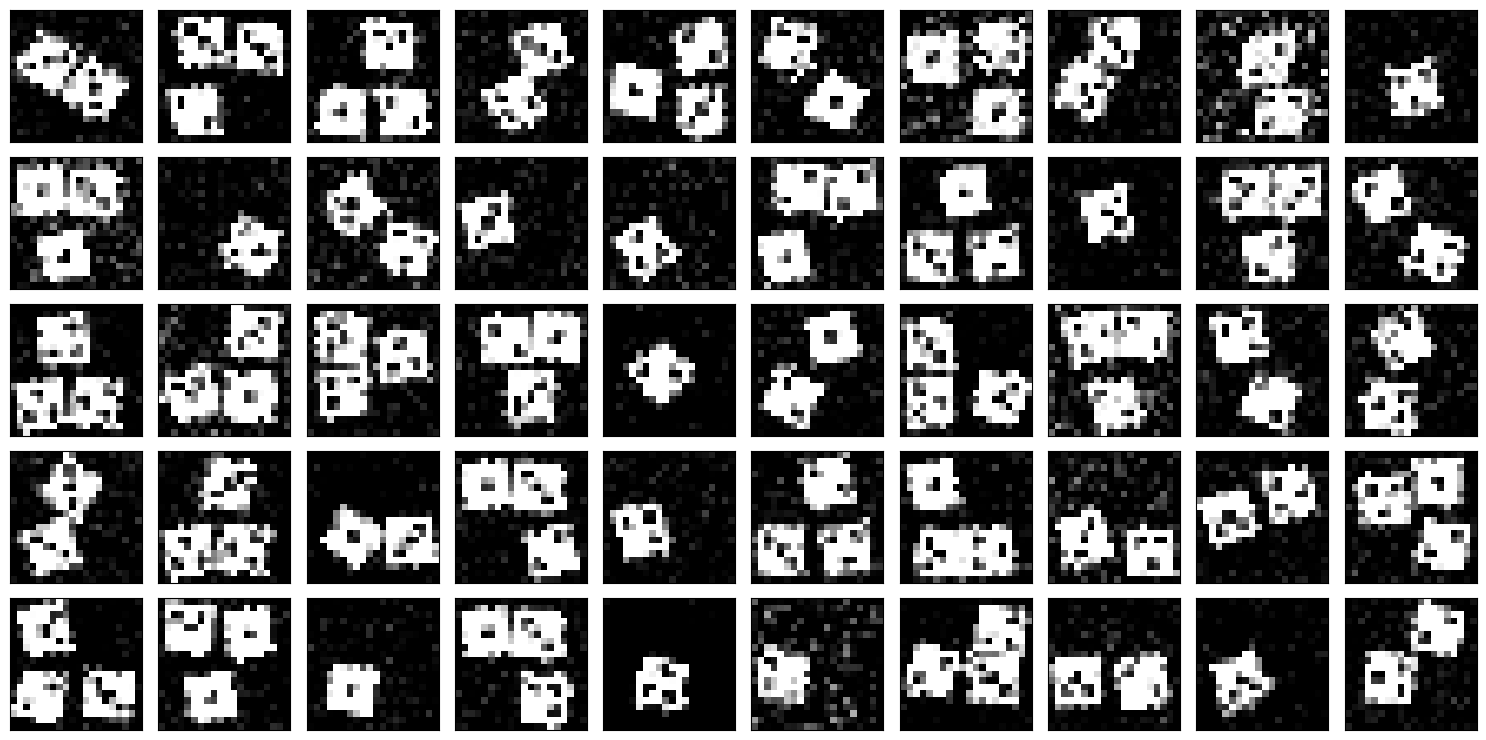

In [28]:
n = 50
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for cnt, i in enumerate(range(n)):
    ax = fig.add_subplot(n//10, 10, cnt+1)
    plt.imshow(X_test[i, :], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

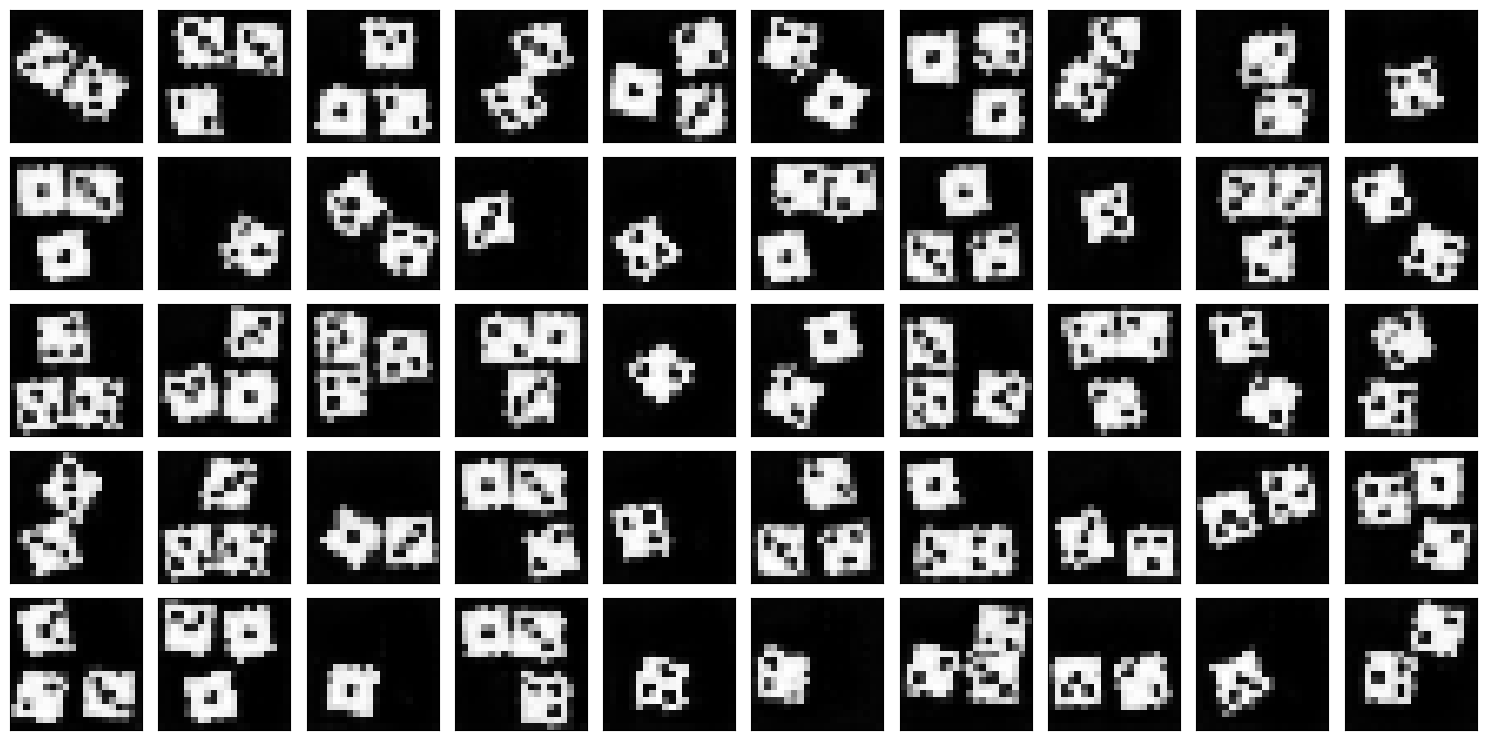

In [32]:
n = 50
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for cnt, i in enumerate(range(n)):
    ax = fig.add_subplot(n//10, 10, cnt+1)
    plt.imshow(pred_imgs[i, :], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

### 保存

In [33]:
len(pred_imgs)

24922

In [31]:
# np.save('/mnt/c/Users/user/MyData/SonyDice/X_test_denoised_by_UNet.npy', pred_imgs)